In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import torch
import numpy as np
import re

SCRIPT_ROOT = Path(".").parent

In [2]:
def parse_accuracy(output_txt, epoch=1):
    d = {}
    flag = False
    with open(output_txt, "r", encoding="latin-1") as f:  
        lines = f.readlines()
        for line in lines:
            if f"***** Evaluating reward, Epoch {epoch}/{epoch} *****" in line:
                flag = True
            if not flag:
                continue

            # ----------------------------------------------------------------
            splits = line.split("acc (higher is better) :")
            if len(splits) > 1:
                d['acc'] = float(splits[1].strip()) * 100
                seg = line.split(":", 1)[1]
                d['chosen'] = float(seg.split(",")[0].split(":")[1].strip())
                d['rejection'] = float(seg.split(",")[1].split(":")[1].strip())
    return d 

In [3]:
def fit_with_quadratics(x, y):
    coefficients = np.polyfit(x, y, 2)

    quadratic_fit = np.poly1d(coefficients)

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = quadratic_fit(x_fit)

    a, b, c = coefficients
    x_vertex = -b / (2 * a)
    y_vertex = quadratic_fit(x_vertex)

    return x_fit, y_fit, x_vertex, y_vertex


def fit_with_robust_quadratic(x, y):
    from sklearn.linear_model import RANSACRegressor, LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline

    X = x.reshape(-1, 1)

    degree = 2 
    ransac = make_pipeline(
        PolynomialFeatures(degree),
        RANSACRegressor(estimator=LinearRegression(), min_samples=0.5, residual_threshold=1.0, random_state=42)
    )

    ransac.fit(X, y)

    model = ransac.named_steps['ransacregressor']
    poly_features = ransac.named_steps['polynomialfeatures']

    inlier_mask = model.inlier_mask_

    X_inliers = poly_features.transform(X[inlier_mask])
    y_inliers = y[inlier_mask]
    linear_model = LinearRegression()
    linear_model.fit(X_inliers, y_inliers)

    coefficients = linear_model.coef_
    intercept = linear_model.intercept_

    quadratic_coefficients = [coefficients[2], coefficients[1], intercept] if degree == 2 else [coefficients[1], intercept]
    quadratic_fit = np.poly1d(quadratic_coefficients)

    x_fit = np.linspace(min(X), max(X), 100)
    y_fit = quadratic_fit(x_fit)

    a, b, c = quadratic_coefficients
    x_vertex = -b / (2 * a)
    y_vertex = quadratic_fit(x_vertex)
    return x_fit, y_fit, x_vertex, y_vertex



In [4]:
fn = "rmstaticpythia70mlastsplr1em5wd1em1ep1"

ep = 1
data = []
l1_list = [0, 10**(-4.5), 10**(-4), 10**(-3.75), 10**(-3.25), 10**(-3), 10**(-2.75), 10**(-2.5), 10**(-2), 10**(-1), 10**(-0.5), 1, 2, 4, 8]
for l1_lambda in l1_list:
    for seed in [i for i in range(5)]:
        output_dir = (
            SCRIPT_ROOT / "output" / fn / f"l1reg{l1_lambda}" / f"seed{seed}"
        )
        output_txt = output_dir / "output.txt"
        d = parse_accuracy(output_txt, epoch=ep)
        d['l1'] = l1_lambda
        d['seed'] = seed
        
        data.append(d)

df = pd.DataFrame(data)

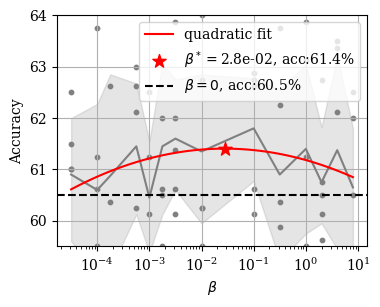

In [5]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Serif'
df_copy = df.copy()
plt.figure(figsize=(4, 3)) 

sns.lineplot(data=df_copy[df_copy['l1'] != 0.], x="l1", y="acc", color='grey')
plt.scatter(df_copy['l1'], df_copy['acc'], color='grey', s=10) 
plt.xscale('log') 

x = df[df['l1'] != 0.]['l1'].apply(np.log10)
y = df[df['l1'] != 0.]['acc']
x_fit, y_fit, x_vertex, y_vertex = fit_with_quadratics(x, y)
x_fit = 10 ** x_fit
x_vertex = 10 ** x_vertex

plt.plot(x_fit, y_fit, color='red', label='quadratic fit')
plt.scatter(x_vertex, y_vertex, color='red', marker='*', s=100, label=fr'$\beta^* =${x_vertex:.1e}, acc:{y_vertex:.1f}%')

mean_acc = df[df['l1'] == 0.]['acc'].mean()
plt.axhline(y=mean_acc, color='black', linestyle='--', label=fr'$\beta=0$, acc:{mean_acc:.1f}%')

plt.ylim(59.5, 64)
plt.grid(True) 
plt.legend()
plt.xlabel(r"$\beta$")  
plt.ylabel("Accuracy") 
plt.savefig('70M_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [6]:
fn = "defaultllama1blastsplr1em5wd1em1ep1"

ep = 1
data = []
l1_list = [0, 10**(-4.5), 10**(-4), 10**(-3.25), 10**(-2.75), 10**(-2.5), 10**(-2), 10**(-1.5), 10**(-1), 10**(-0.5), 1, 2, 4]
for l1_lambda in l1_list:
    for seed in [i for i in range(5)]:
        output_dir = (
            SCRIPT_ROOT / "output" / fn / f"l1reg{l1_lambda}" / f"seed{seed}"
        )
        output_txt = output_dir / "output.txt"
        d = parse_accuracy(output_txt, epoch=ep)
        d['l1'] = l1_lambda
        d['seed'] = seed
        
        data.append(d)

df = pd.DataFrame(data)

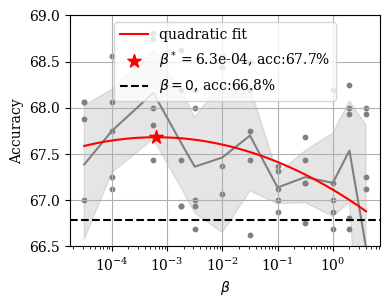

In [7]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Serif'
df_copy = df.copy()
plt.figure(figsize=(4, 3)) 

sns.lineplot(data=df_copy[df_copy['l1'] != 0.], x="l1", y="acc", color='grey')
plt.scatter(df_copy['l1'], df_copy['acc'], color='grey', s=10)
plt.xscale('log')
x = df[df['l1'] != 0.]['l1'].apply(np.log10)
y = df[df['l1'] != 0.]['acc']
x_fit, y_fit, x_vertex, y_vertex = fit_with_quadratics(x, y)
x_fit = 10 ** x_fit
x_vertex = 10 ** x_vertex

plt.plot(x_fit, y_fit, color='red', label='quadratic fit')
plt.scatter(x_vertex, y_vertex, color='red', marker='*', s=100, label=fr'$\beta^* =${x_vertex:.1e}, acc:{y_vertex:.1f}%')

mean_acc = df[df['l1'] == 0.]['acc'].mean()
plt.axhline(y=mean_acc, color='black', linestyle='--', label=fr'$\beta=0$, acc:{mean_acc:.1f}%')

plt.ylim(66.5, 69)
plt.grid(True) 
plt.legend()
plt.xlabel(r"$\beta$")  
plt.ylabel("Accuracy")  
plt.savefig('1B_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()
